## Import data and libraries

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import math as mt
from pylab import savefig

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "./input/"]).decode("utf8"))

# preprocessing/decomposition
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

#Import Keras libraries
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.recurrent import LSTM
# define custom R2 metrics for Keras backend
from keras import backend as K
# to tune the NN
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam

# model evaluation
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error

# feature selection
from sklearn.feature_selection import f_regression, mutual_info_regression, VarianceThreshold

# define path to save model
import os
model_path = 'keras_model.h5'

# to make results reproducible
seed = 42

# Read datasets
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv')

# Remove the outlier
# train=train[train.y<250]

# save IDs for submission
id_test = test['ID'].copy()

## Prepare data

In [13]:
# glue datasets together
total = pd.concat([train, test], axis=0)
print('initial shape: {}'.format(total.shape))

# binary indexes for train/test set split
is_train = ~total.y.isnull()

# find all categorical features
cf = total.select_dtypes(include=['object']).columns

# make one-hot-encoding convenient way - pandas.get_dummies(df) function
dummies = pd.get_dummies(
    total[cf],
    drop_first=False # you can set it = True to ommit multicollinearity (crucial for linear models)
)

print('oh-encoded shape: {}'.format(dummies.shape))

# get rid of old columns and append them encoded
total = pd.concat(
    [
        total.drop(cf, axis=1), # drop old
        dummies # append them one-hot-encoded
    ],
    axis=1 # column-wise
)

print('appended-encoded shape: {}'.format(total.shape))

# recreate train/test again, now with dropped ID column
train, test = total[is_train].drop(['ID'], axis=1), total[~is_train].drop(['ID', 'y'], axis=1)

# drop redundant objects
del total

# check shape
print('\nTrain shape: {}\nTest shape: {}'.format(train.shape, test.shape))


# X, y preparation
X, y = train.drop('y', axis=1).copy().values, train.y.values
X_test = test.values
print('\nTrain shape No Feature Selection: {}\nTest shape No Feature Selection: {}'.format(X.shape, X_test.shape))

"""Return the sample arithmetic mean of data."""
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)
"""Return sum of square deviations of sequence data."""    
def sum_of_square_deviation(numbers,mean):
    return float(1/len(numbers) * sum((x - mean)** 2 for x in numbers))

# train/validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=seed
)

initial shape: (8418, 378)
oh-encoded shape: (8418, 211)
appended-encoded shape: (8418, 581)

Train shape: (4209, 580)
Test shape: (4209, 579)

Train shape No Feature Selection: (4209, 579)
Test shape No Feature Selection: (4209, 579)


## Compress features by autoencoder

In [14]:
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [45]:
from keras.layers import Input, Dense
from keras.models import Model


# initialize input dimension
input_dims = train.shape[1]-1

# this is the size of our encoded representations
encoding_dim = 40  # 32 floats 

# this is our input placeholder
input_placeholder = Input(shape=(579,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_placeholder)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(579, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_placeholder, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_placeholder, encoded)

autoencoder.compile(optimizer='rmsprop', 
                    loss='mean_squared_error',
                    metrics=[r2_keras,"mse"])

autoencoder.summary()


# prepare callbacks

# enc_model_path = 'encoder_model.h5'

# callbacks = [
#     EarlyStopping(
#         monitor='val_r2_keras', 
#         patience=20,
#         mode='max',
#         verbose=1),
#     ModelCheckpoint(
#         enc_model_path, 
#         monitor='val_r2_keras', 
#         save_best_only=True, 
#         mode='max',
#         verbose=0)
# ]



autoencoder.fit(X_tr, X_tr,
                epochs=150,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, X_val),
                verbose =2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 579)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 40)                23200     
_________________________________________________________________
dense_50 (Dense)             (None, 579)               23739     
Total params: 46,939.0
Trainable params: 46,939.0
Non-trainable params: 0.0
_________________________________________________________________
Train on 3367 samples, validate on 842 samples
Epoch 1/150
3s - loss: 0.0661 - r2_keras: 0.3451 - mean_squared_error: 0.0661 - val_loss: 0.0417 - val_r2_keras: 0.5872 - val_mean_squared_error: 0.0417
Epoch 2/150
0s - loss: 0.0333 - r2_keras: 0.6706 - mean_squared_error: 0.0333 - val_loss: 0.0275 - val_r2_keras: 0.7280 - val_mean_squared_error: 0.0275
Epoch 3/150
0s - loss: 0.0238 - r2_keras: 0

In [46]:
encoded_X_train = encoder.predict(X)
encoded_X_test = encoder.predict(X_test)

# train/validation split of encoded_data
X_enc_tr, X_enc_val, y_tr, y_val = train_test_split(
    encoded_X_train, 
    y, 
    test_size=0.2, 
    random_state=seed
)

## GENERATE MODEL

In [47]:
def model():
    model = Sequential()
    # Input layer with dimension input_dims and hidden layer i with input_dims neurons. 
    model.add(Dense(input_dims, input_dim=input_dims, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Activation("linear"))
    # Hidden layer
    model.add(Dense(input_dims, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Activation("linear"))
    # Hidden layer
    model.add(Dense(input_dims, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Activation("linear"))
    # Hidden layer
    model.add(Dense(input_dims, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Activation("linear"))
    # Hidden layer
    model.add(Dense(input_dims//2, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Activation("linear"))
    # Output Layer.
    model.add(Dense(1))
    # Use a large learning rate with decay and a large momentum. 
    # Increase your learning rate by a factor of 10 to 100 and use a high momentum value of 0.9 or 0.99
    # sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    # compile this model
    model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as alternative
                  optimizer='rmsprop',
                  metrics=[r2_keras,"mse"] # you can add several if needed
                 )
    
    # Visualize NN architecture
    print(model.summary())
    return model

def model2():

    model2 = Sequential()
    # Input layer with dimension input_dims and hidden layer i with input_dims neurons. 
    model2.add(Dense(input_dims, 
                    input_dim=input_dims, 
                    activation='relu',
                    kernel_constraint=maxnorm(3)))
    model2.add(BatchNormalization())
    model2.add(Dropout(0.2))
    
#     # Hidden layer1
#     model2.add(Dense(20, init = 'he_normal'))
#     model2.add(Activation('relu'))
#     model2.add(BatchNormalization())    
    
    # Hidden layer2
    model2.add(Dense(4, kernel_initializer='normal'))
    model2.add(Activation('relu'))
    model2.add(Dropout(0.3))
    model2.add(BatchNormalization())    
    
    #output
    model2.add(Dense(1, kernel_initializer='normal'))
    model2.compile(loss = 'mean_squared_error', 
                   optimizer = 'adam',
                   metrics=[r2_keras,"mse"])
    
    # Visualize NN architecture
    print(model2.summary())
    return model2

In [48]:
# initialize input dimension

# input_dims = train.shape[1]-1
input_dims =encoding_dim
# input_dims = train_reduced.shape[1]
    
# make np.seed fixed
np.random.seed(seed)

# initialize estimator, wrap model in KerasRegressor
estimator = KerasRegressor(
    build_fn=model, 
    nb_epoch=300, 
    batch_size=32,
    verbose=1
)


# prepare callbacks
callbacks = [
    EarlyStopping(
        monitor='val_r2_keras', 
        patience=120,
        mode='max',
        verbose=1),
    ModelCheckpoint(
        model_path, 
        monitor='val_r2_keras', 
        save_best_only=True, 
        mode='max',
        verbose=0)
]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 40)                1640      
_________________________________________________________________
batch_normalization_16 (Batc (None, 40)                160       
_________________________________________________________________
dropout_16 (Dropout)         (None, 40)                0         
_________________________________________________________________
activation_16 (Activation)   (None, 40)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 40)                1640      
_________________________________________________________________
batch_normalization_17 (Batc (None, 40)                160       
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
__________

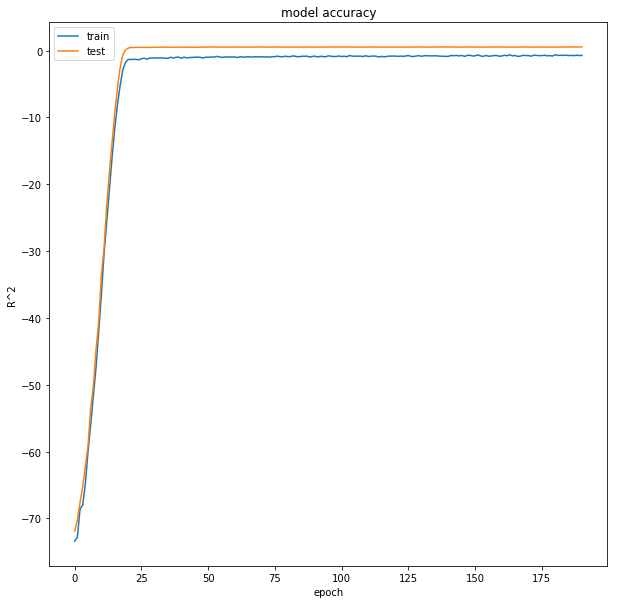

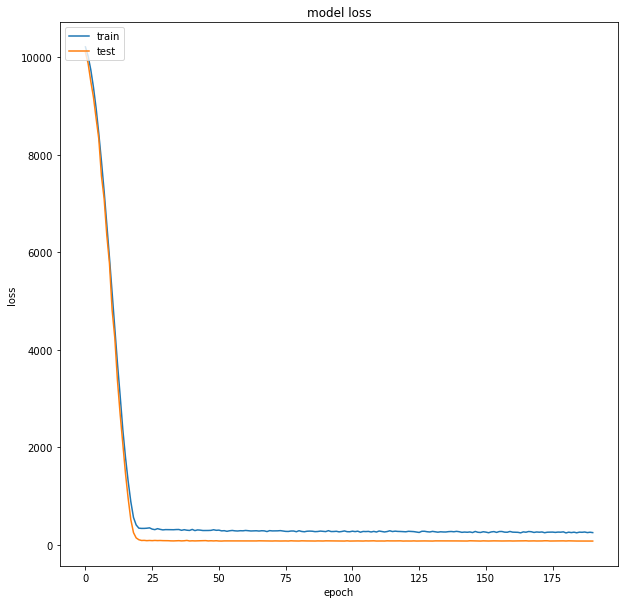

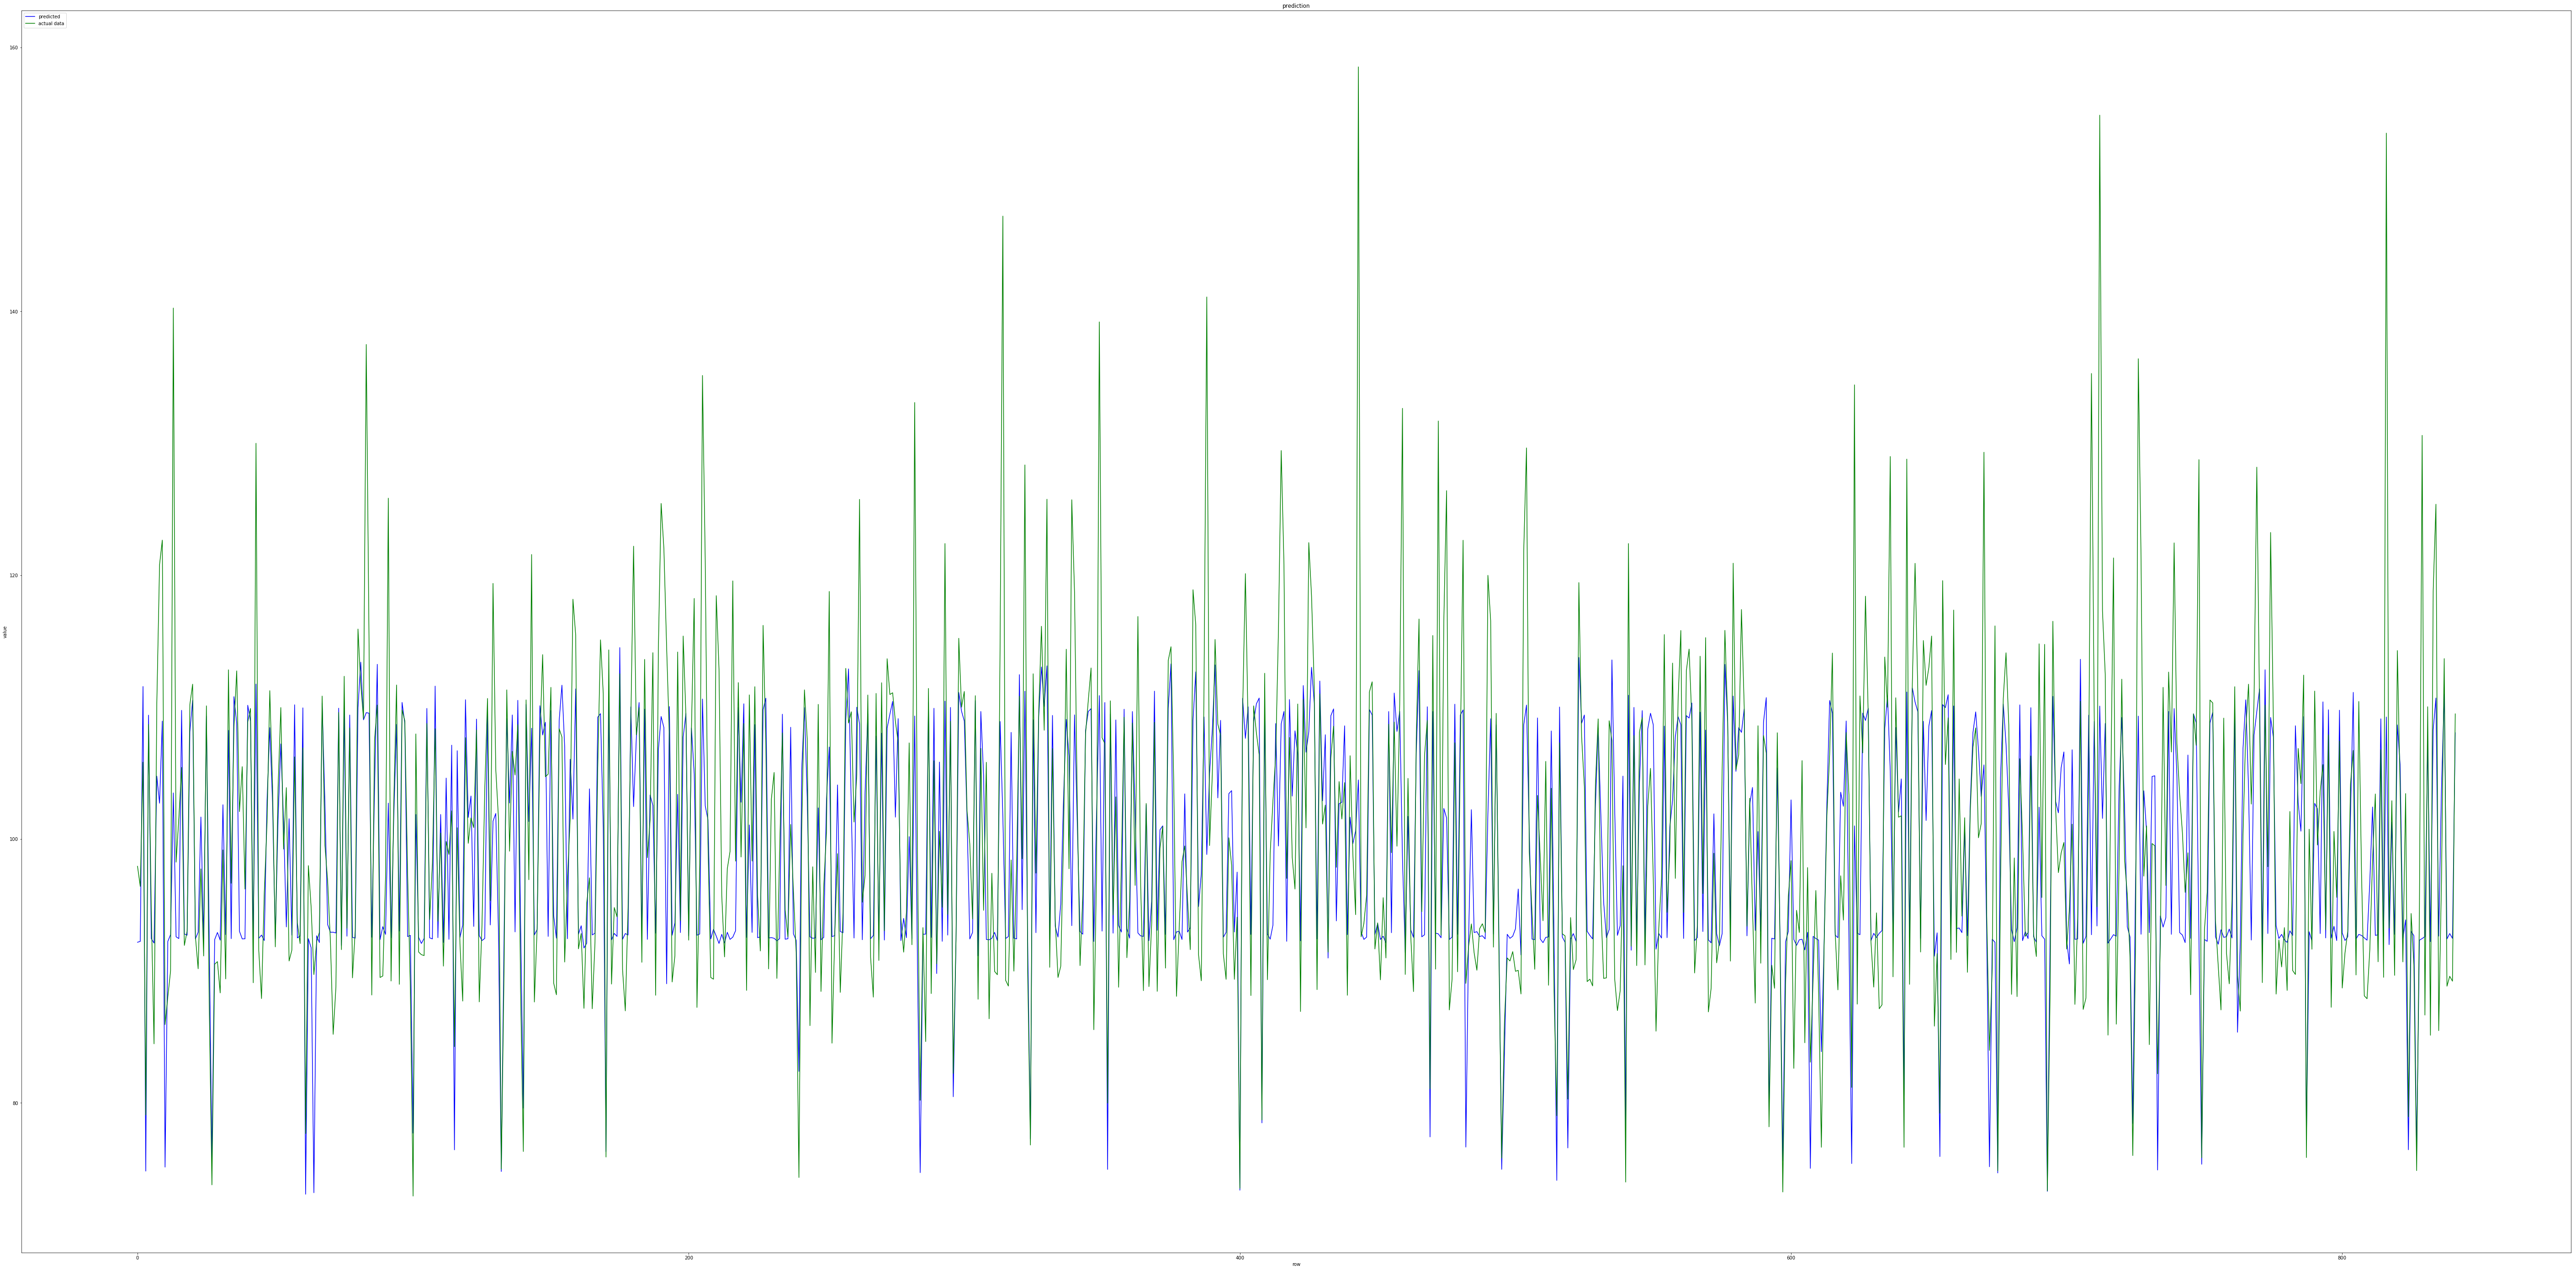

MSE train: 8.725929722526457
R^2 train: 0.5299803936077073
MSE val: 8.481751879545246
R^2 val: 0.5378082695663507


In [49]:
# fit estimator
history = estimator.fit(
    X_enc_tr, 
    y_tr, 
    epochs=500,
    validation_data=(X_enc_val, y_val),
    verbose=2,
    callbacks=callbacks,
    shuffle=True
)

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model accuracy')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_accuracy.png")

# summarize history for loss
fig_loss = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_loss.savefig("model_loss.png")

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path, custom_objects={'r2_keras': r2_keras})

# Plot in blue color the predicted data and in green color the
# actual data to verify visually the accuracy of the model.
predicted = estimator.predict(X_enc_val)
fig_verify = plt.figure(figsize=(100, 50))
plt.plot(predicted, color="blue")
plt.plot(y_val, color="green")
plt.title('prediction')
plt.ylabel('value')
plt.xlabel('row')
plt.legend(['predicted', 'actual data'], loc='upper left')
plt.show()
fig_verify.savefig("model_verify.png")

# check performance on train set
print('MSE train: {}'.format(mean_squared_error(y_tr, estimator.predict(X_enc_tr))**0.5)) # mse train
print('R^2 train: {}'.format(r2_score(y_tr, estimator.predict(X_enc_tr)))) # R^2 train

# check performance on validation set
print('MSE val: {}'.format(mean_squared_error(y_val, estimator.predict(X_enc_val))**0.5)) # mse val
print('R^2 val: {}'.format(r2_score(y_val, estimator.predict(X_enc_val)))) # R^2 val
pass

In [50]:
# predict results
res = estimator.predict(encoded_X_test).ravel()
print(res)

# create df and convert it to csv
output = pd.DataFrame({'id': id_test, 'y': res})
output.to_csv('keras-baseline.csv', index=False)

[  76.15569305   93.03762054   76.7450943  ...,   93.07406616  108.7339859
   92.811409  ]
